In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-data/hourly_data.csv


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
data=pd.read_csv('../input/hourly-data/hourly_data.csv')

In [4]:
data.columns

Index(['date_time', 'AC 1', 'AC 2', 'AC 3', 'AC 4', 'AC 5', 'AC 6', 'AC 7',
       'AC 8', 'AC 9', 'AC 10', 'AC 11', 'AC 12', 'AC 13', 'AC 14', 'AC 15',
       'AC 16', 'AC 17', 'AC 18', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'city', 'date', 'holiday_flag'],
      dtype='object')

In [5]:
data.drop(['maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph',  'precipMM',
       'pressure',  'visibility', 'winddirDegree', 'windspeedKmph',
       'city', 'date', 'holiday_flag'],axis=1,inplace=True)

In [6]:
data.head()

,date_time,AC 1,AC 2,AC 3,AC 4,AC 5,AC 6,AC 7,AC 8,AC 9,...,AC 13,AC 14,AC 15,AC 16,AC 17,AC 18,DewPointC,cloudcover,humidity,tempC
0,2019-08-01 00:00:00,6.841507,8.501703,1.801855,0.975186,2.232007,4.302977,2.677340,4.825840,3.652807,...,4.692234,5.199325,5.651866,4.244085,2.632695,5.172505,21,15,56,31
1,2019-08-01 01:00:00,7.407684,8.459075,1.490131,1.842207,2.236677,4.314749,2.610280,4.463227,3.053721,...,5.108711,5.699031,5.942294,4.612226,2.580214,3.970979,22,19,58,31
2,2019-08-01 02:00:00,7.350885,8.113246,1.482323,1.465390,1.991346,4.216204,2.753061,3.801375,3.115622,...,4.034610,5.022749,6.213989,5.267167,2.734928,3.949934,22,23,60,31
3,2019-08-01 03:00:00,6.639281,7.923313,2.238207,1.440677,2.091048,4.734834,3.044784,3.895697,2.844864,...,4.400518,5.034446,4.935977,5.001503,4.238698,3.898287,22,28,62,30
4,2019-08-01 04:00:00,6.597653,7.300900,1.744991,2.547984,1.872143,3.600600,2.918532,3.768754,3.383187,...,3.972867,4.283286,5.323463,4.811916,4.192009,3.937752,23,28,61,31


In [7]:
data['date_time']=pd.to_datetime(data['date_time'])

In [8]:
data.set_index('date_time',inplace=True)

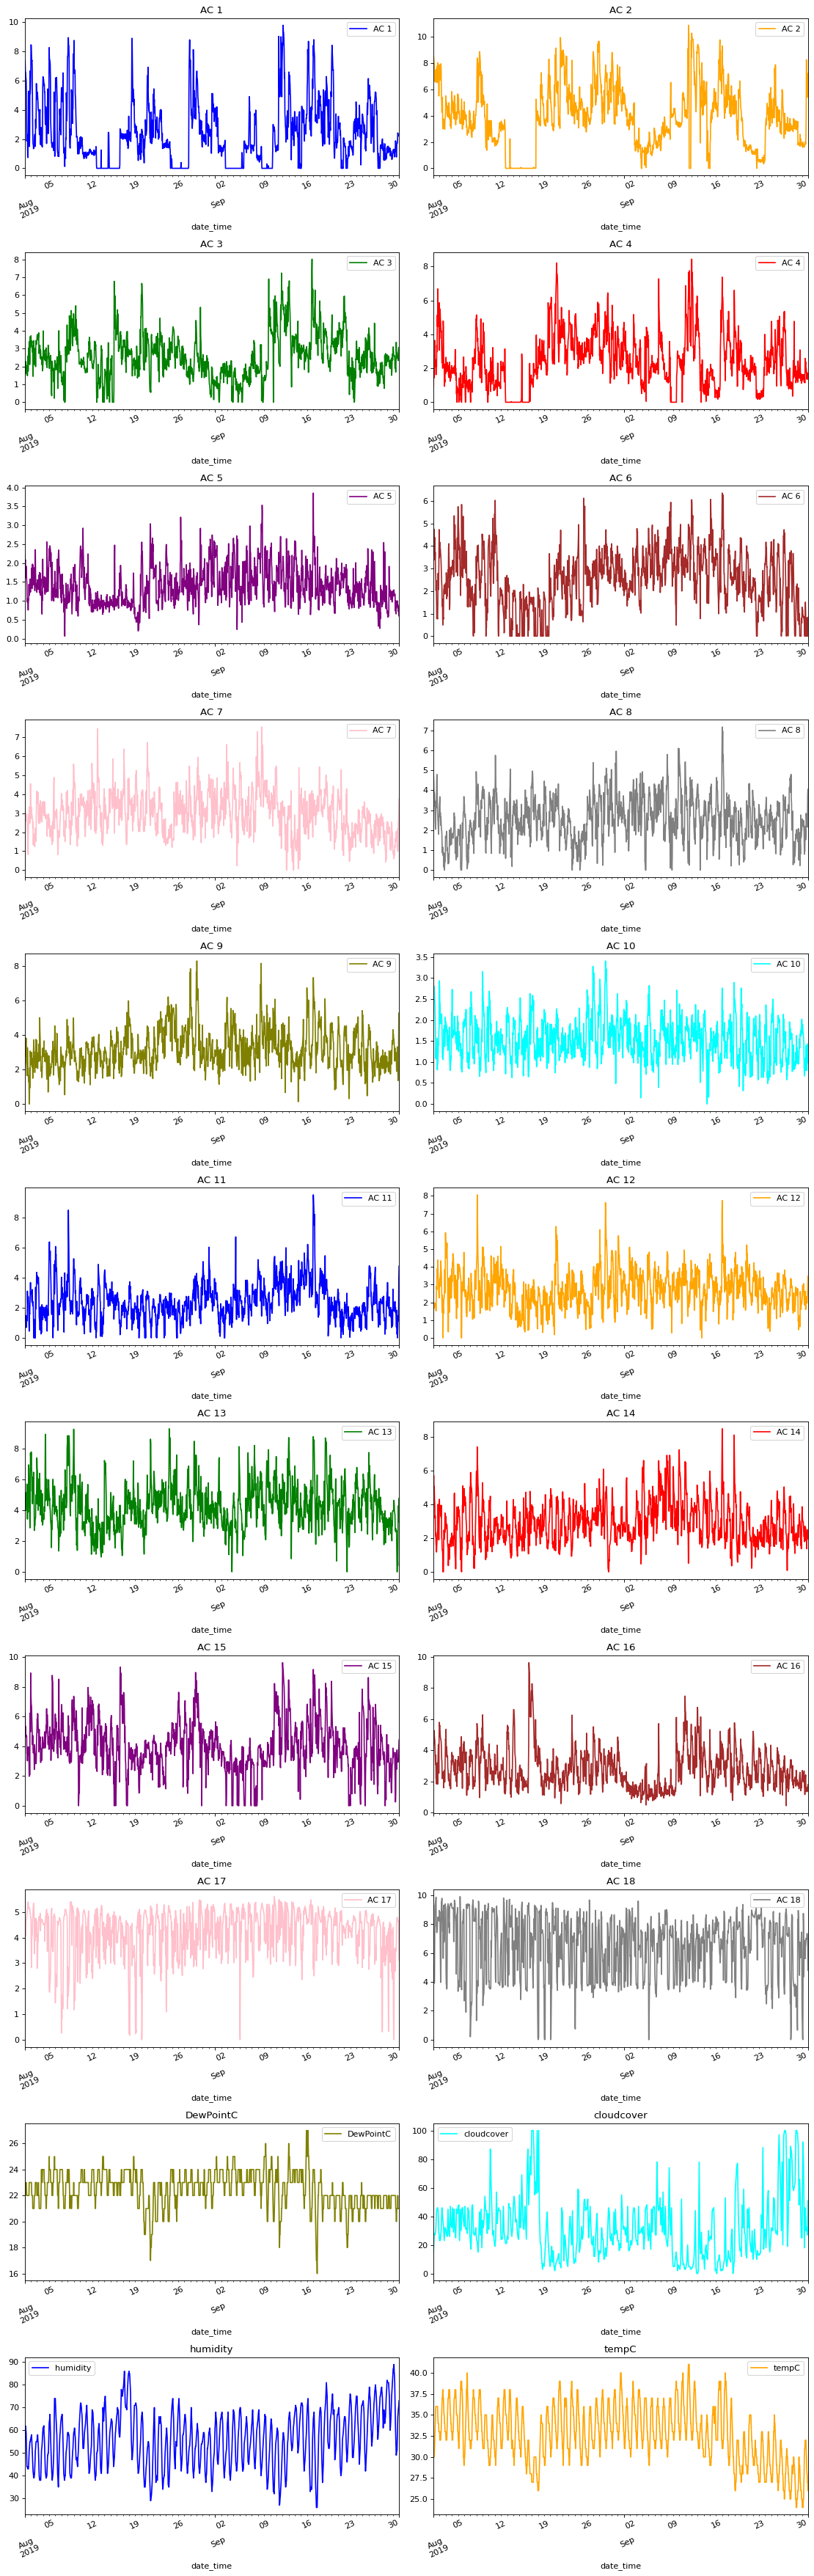

In [9]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def Visualize(df):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(data)

In [10]:
df_input=data[['AC 1','cloudcover','humidity']]


In [11]:
df_input.shape

(1464, 3)

In [12]:
df_train = df_input[:int(0.9*(len(df_input)))]
df_test = df_input[int(0.9*(len(df_input))):]

In [13]:
df_train.head()


,AC 1,cloudcover,humidity
date_time,,,
2019-08-01 00:00:00,6.841507,15,56
2019-08-01 01:00:00,7.407684,19,58
2019-08-01 02:00:00,7.350885,23,60
2019-08-01 03:00:00,6.639281,28,62
2019-08-01 04:00:00,6.597653,28,61


In [14]:
df_test.shape


(147, 3)

In [15]:
model = VAR(df_train, freq="1H")
for i in range(48):
    results = model.fit(i+1)
    print('Order = ', i+1)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)

Order =  1
AIC:  5.120582294439076
BIC:  5.1678377848210095
Order =  2
AIC:  3.5812830325156404
BIC:  3.6640308886653354
Order =  3
AIC:  3.514985096559112
BIC:  3.6332689138888967
Order =  4
AIC:  3.3824369970811925
BIC:  3.536300458694147
Order =  5
AIC:  3.2505083574565314
BIC:  3.4399952343896056
Order =  6
AIC:  3.2438740349416295
BIC:  3.4690281864096164
Order =  7
AIC:  3.1983530777732034
BIC:  3.459218451413572
Order =  8
AIC:  3.1276078480102556
BIC:  3.4242284801288516
Order =  9
AIC:  3.109399077031135
BIC:  3.4418190928487498
Order =  10
AIC:  3.0794536250023468
BIC:  3.4477172389021575
Order =  11
AIC:  3.059759277820732
BIC:  3.4639107935966202
Order =  12
AIC:  3.054784742151077
BIC:  3.4948685532568273
Order =  13
AIC:  3.022700018785943
BIC:  3.4987606085853233
Order =  14
AIC:  3.012234525796412
BIC:  3.524316467814144
Order =  15
AIC:  2.9678036268807766
BIC:  3.5159515850543976
Order =  16
AIC:  2.8504646231873867
BIC:  3.4347233521200065
Order =  17
AIC:  2.8553553

In [16]:
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Dec, 2021
Time:                     04:03:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.45280
Nobs:                     1269.00    HQIC:                   3.35145
Log likelihood:          -6672.95    FPE:                    14.7584
AIC:                      2.68881    Det(Omega_mle):         10.6678
--------------------------------------------------------------------
Results for equation AC 1
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.214552         0.291923            0.735           0.462
L1.AC 1                0.862887         0.029759           28.995           0.000
L1.cloudcover         -0.005068         0.007124         

In [17]:
lag=results.k_ar


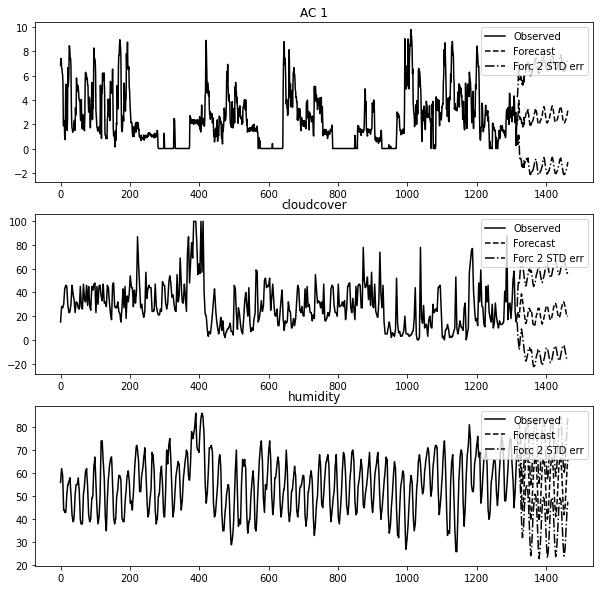

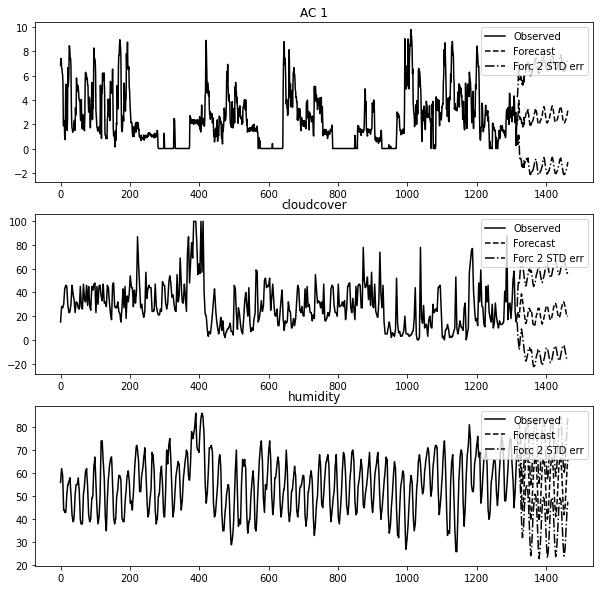

In [18]:
results.plot_forecast(147)
